# Data Acquisition and Cleaning

In [14]:
!brew install cmake
!pip install dlib
!pip install face_recognition
!pip install matplotlib

To reinstall 3.26.3, run:
  brew reinstall cmake


In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import face_recognition

## Load Data

The dataset consists of three sources, including two facial image datasets and one eye dataset, that contain various attributes such as grayscale, RGB, high/low quality, gender, glasses, and diverse facial structures.

Labeled Faces in the Wild (both eyes open):  https://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html <br>
Closed Faces in the Wild (both eyes closed): http://vis-www.cs.umass.edu/lfw/ <br>
Kaggle Dataset: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset

In [16]:
def load_images(dir, eye_state):
    """
    Takes a directory path and an integer eye_state as inputs 
    and returns a list of images with corresponding eye states.

    Args:
        dir (str): the path of the directory containing the images.
        eye_state (int): the binary label of eye state (0 for open and 1 for closed).

    Returns:
        images (list): a list of images with corresponding eye states 
            in the form of [image, eye_state] pairs.
    """
    images = []
    for filename in os.listdir(dir):
        img = face_recognition.load_image_file(os.path.join(dir,filename))
        images.append([img, eye_state])
    return images

In [17]:
# Load open eye images
open = load_images('data/face_data/open_face', 0)

# Load closed eye images
closed = load_images('data/face_data/closed_face', 1)

data = open + closed
random.shuffle(data)

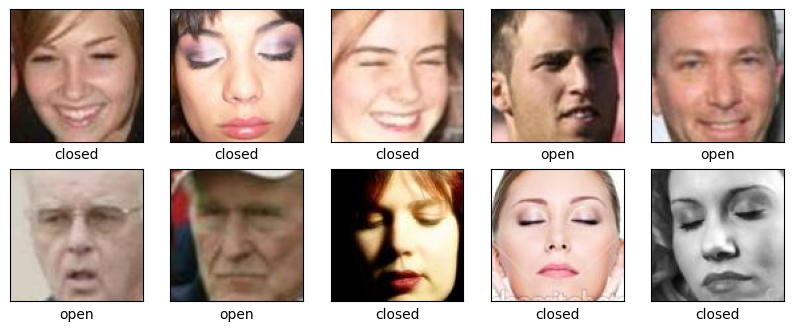

In [18]:
# Display 10 sample images
X = [] 
y = [] 
class_names = ['open', 'closed']

for features, label in data: 
     X.append(features)
     y.append(label)
y = np.array(y)

plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y[i]],)

## Data Preprocessing

### 1. Identify Facial Landmarks

Used face_recognition library to detect the key facial structures on the face ROI. face_recognition is built using dlib’s state-of-the-art face recognition and claims to have an accuracy of 99.38%. 

dlib’s implementation of facial landmark detector uses a training set of labeled facial landmarks on an image.
These images are manually labeled, specifying 68 (x, y)-coordinates of regions surrounding each facial structure. 
Given this training data, an ensemble of regression trees are trained to estimate the facial landmark positions directly from the pixel intensities themselves.

In [19]:
# Load the jpg file into a numpy array
image = face_recognition.load_image_file('data/face_data/open_face/OpenFace_10.jpg')    
# Find all facial features in all the faces in the image
face_landmarks_list = face_recognition.face_landmarks(image)
# Create a PIL imagedraw object to draw on the image
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)
        
for face_landmarks in face_landmarks_list:
    # Trace out each facial feature in the image with a line
    for facial_feature in face_landmarks.keys():
        if facial_feature == 'left_eye' or facial_feature == 'right_eye':
            d.point(face_landmarks[facial_feature], fill='#00B612')
        else:
            d.point(face_landmarks[facial_feature])

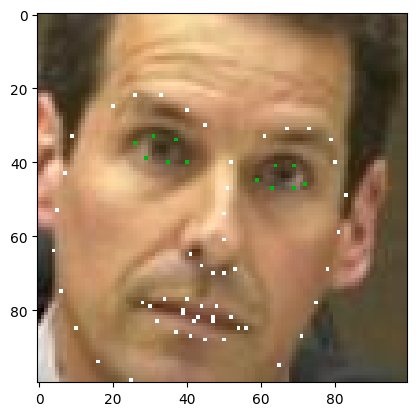

In [20]:
plt.imshow(pil_image)

### 2. Capture Eye Cordinates and Crop Eyes

Cropped images, based on the (x,y)-coordinates of the eye (right eye points: 37–42, left eye points: 43–47). To make sure the full eye is captured, the coordinates of a square that has 50% cushion were added to the axis
Finally, resized & gray scaled cropped images,

In [21]:
def eye_cropper(dir, eye_file):
    """
    Crop and saves eye images from facial images in the given directory.

    Args:
        dir (str): Path to the directory containing facial images
        eye_file (str): Path and prefix to use for saving the eye images

    The function crops the left and right eye regions from each facial image in the
    specified directory using face detection and landmark recognition provided by the
    face_recognition library. The eye regions are then resized to 80x80 pixels, converted
    to grayscale, and saved as separate image files in the specified directory with a 
    unique numerical suffix appended to the given file name prefix.
    """
    count = 1
    for file in os.listdir(dir):
        
        # identify facial feature cordinates
        image = face_recognition.load_image_file(dir + '/' + file)
        face_landmarks_list = face_recognition.face_landmarks(image)
    
        # capture the eye cordinates
        eyes = []
        try:
            eyes.append(face_landmarks_list[0]['left_eye'])
            eyes.append(face_landmarks_list[0]['right_eye'])
        except:
            continue
        
        for eye in eyes:
            x_max = max([coordinate[0] for coordinate in eye])
            x_min = min([coordinate[0] for coordinate in eye])
            y_max = max([coordinate[1] for coordinate in eye])
            y_min = min([coordinate[1] for coordinate in eye])
   
            x_range = x_max - x_min
            y_range = y_max - y_min
        
            # add 50% cushion
            if x_range > y_range:
                right = round(.5*x_range) + x_max
                left = x_min - round(.5*x_range)
                bottom = round(((right-left) - y_range))/2 + y_max
                top = y_min - round(((right-left) - y_range))/2
            else:
                bottom = round(.5*y_range) + y_max
                top = y_min - round(.5*y_range)
                right = round(((bottom-top) - x_range))/2 + x_max
                left = x_min - round(((bottom-top) - x_range))/2
        
            im = Image.open(dir + '/' + file)
        
            # crop the image using the cushioned coordinates
            im = im.crop((left, top, right, bottom))
    
            # resize the image
            im = im.resize((80,80))
        
            # grayscale the image
            im = im.convert('L')
            
            im.save(eye_file + str(count) + '.jpg')
        
            count += 1

In [25]:
eye_cropper('data/face_data/open_face', 'data/eye_data/open_eye/open_')
eye_cropper('data/face_data/closed_face', 'data/eye_data/closed_eye/closed_')

In [48]:
# Load preprocessed open eye images
open = load_images('data/eye_data/open_eye', 0)

# Load preprocessed closed eye images
closed = load_images('data/eye_data/closed_eye', 1)

data = open + closed
random.shuffle(data)

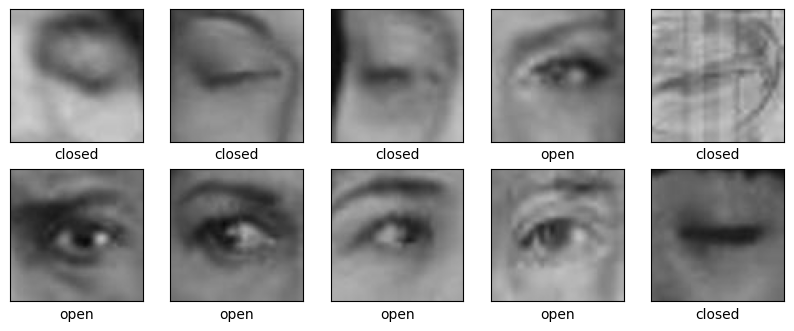

In [49]:
# Load 10 sample preprocessed images
X = [] 
y = [] 
class_names = ['open', 'closed']

for features, label in data: 
     X.append(features)
     y.append(label)
y = np.array(y)

plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[y[i]],)